In [23]:
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import matplotlib.gridspec as gridspec
import seaborn as sns
from mpl_toolkits import mplot3d
from scipy import stats
%matplotlib inline

# # preprocessing
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
import pandas_profiling as pp
from scipy.stats import pearsonr

# model tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe, space_eval

import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from mlxtend.regressor import StackingCVRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import scipy.stats as stats
import sklearn.linear_model as linear_model


In [24]:
df = pd.read_csv('housedata.csv')

df.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [26]:
quantitative = [f for f in df.columns if df.dtypes[f] != 'object']
quantitative.remove('Id')
qualitative = [f for f in df.columns if df.dtypes[f] == 'object']

<AxesSubplot:title={'center':'Log Normal'}, xlabel='SalePrice', ylabel='Density'>

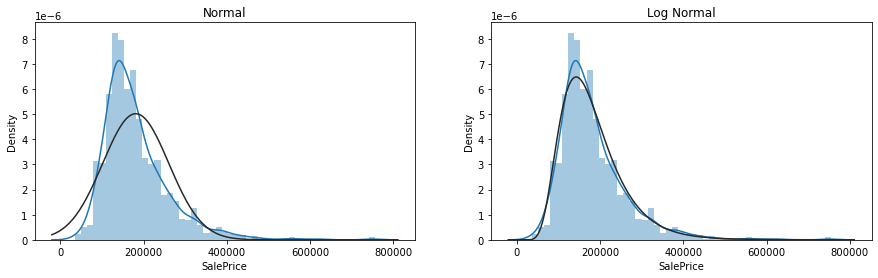

In [27]:
f, (ax1, ax2) = plt.subplots(1, 2)
f.set_figwidth(15, forward=True)
ax1.set_title('Normal')
sns.distplot(df['SalePrice'], fit=stats.norm, ax=ax1)
ax2.set_title('Log Normal')
sns.distplot(df['SalePrice'], fit=stats.lognorm, ax=ax2)

Phân bố của biến SalePrice không phải là phân bố chuẩn (normal) mà giống với phân bố log-normal.
Vì vậy, trước khi đưa vào thuật toán Machine Learning, biến SalePrice cần được biến đổi bằng log transformation.

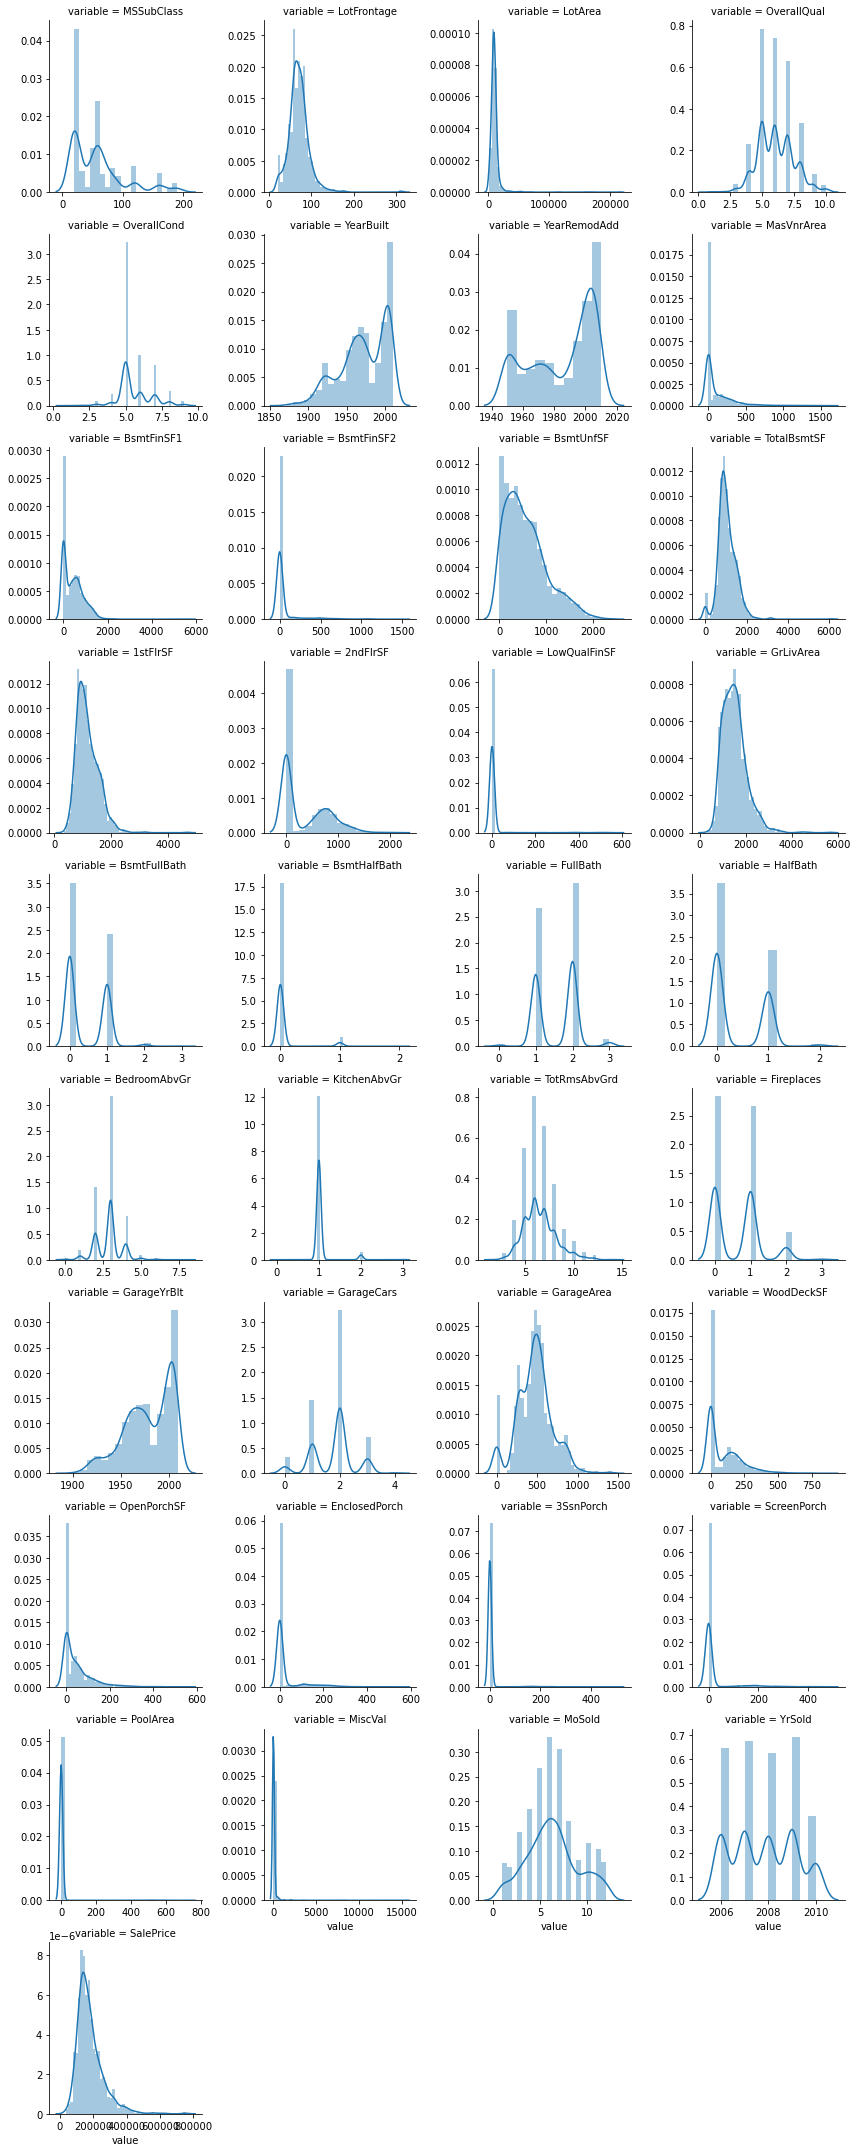

In [28]:
f = pd.melt(df, value_vars=quantitative)
grid = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
grid = grid.map(sns.distplot, 'value')

Có thể thấy, có một vài biến cần phải biến đổi log transformation như: TotalBsmtSF, KitchenAbvGr, LotFrontage, LotArea, ...

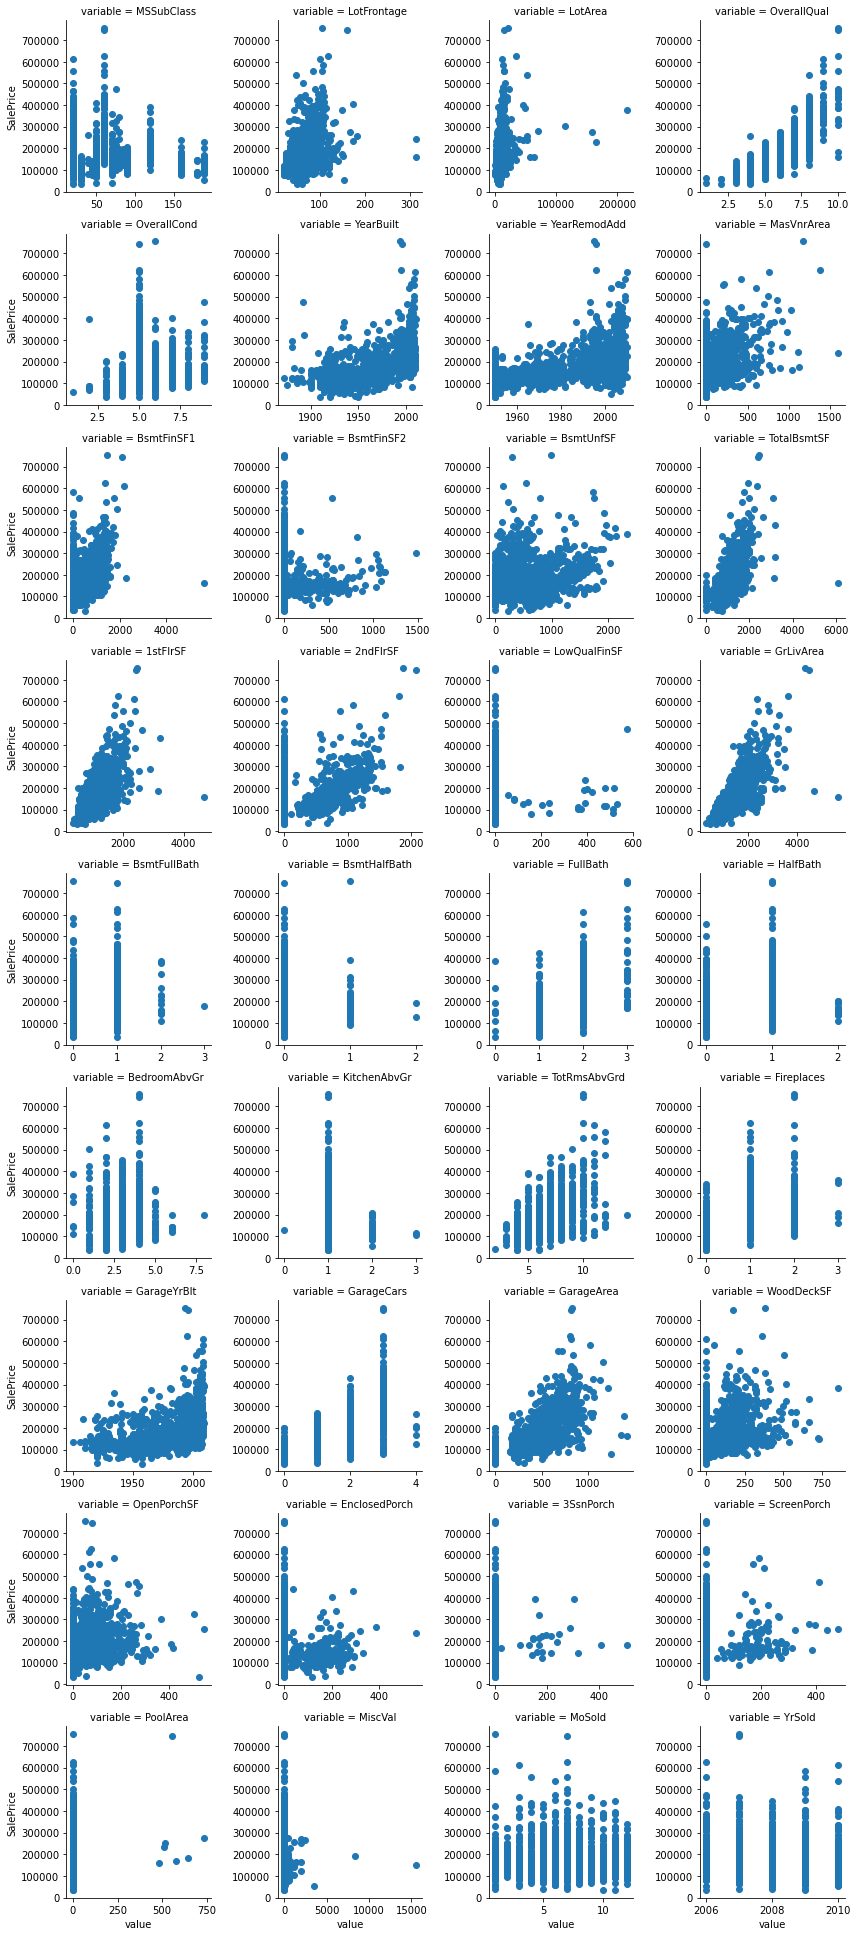

In [29]:
quantitative.remove('SalePrice')
f = pd.melt(df, id_vars=['SalePrice'], value_vars=quantitative)
grid = sns.FacetGrid(f, col='variable',  col_wrap=4, sharex=False, sharey=False)
grid = grid.map(plt.scatter, 'value', 'SalePrice')

Qua phân tích các scatter plot, các biến như LotFrontage, LotArea, OverallQual, TotalBsmtSF, ... có quan hệ tuyến tính (linear) với SalePrice. Một số biến khác như BsmtFullBath, HalfBath, Fireplaces, ... lại có thể biễu diễn SalePrice thông qua phương trình bậc hai (quadratic equation).

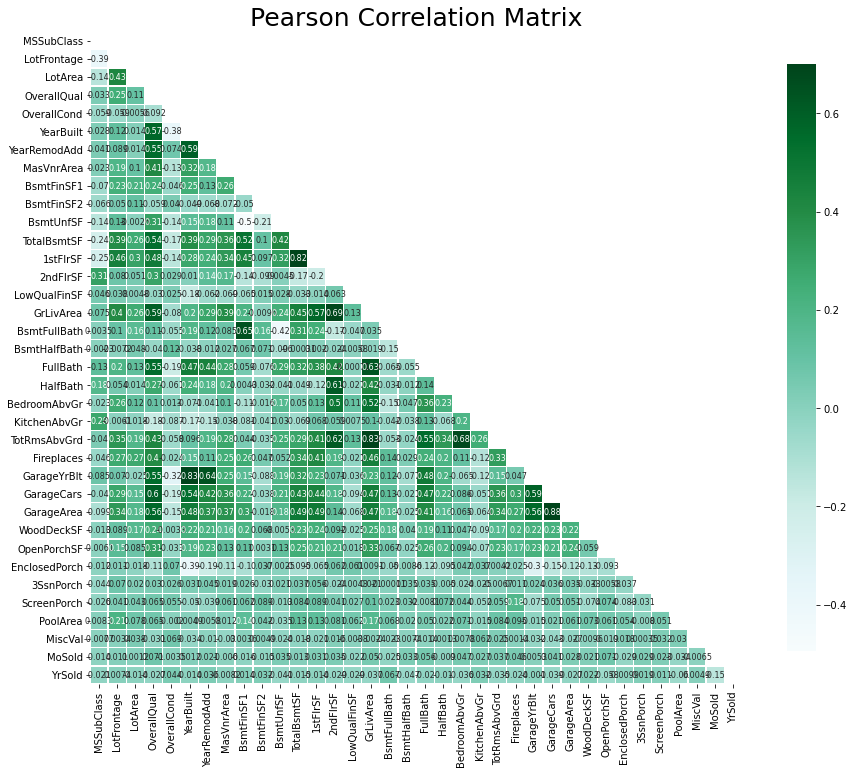

In [30]:
mask = np.zeros_like(df[quantitative].corr(), dtype=np.bool) 
mask[np.triu_indices_from(mask)] = True 

f, ax = plt.subplots(figsize=(16, 12))
plt.title('Pearson Correlation Matrix',fontsize=25)

sns.heatmap(df[quantitative].corr(),linewidths=0.25,vmax=0.7,square=True,cmap="BuGn", #"BuGn_r" to reverse 
            linecolor='w',annot=True,annot_kws={"size":8},mask=mask,cbar_kws={"shrink": .9});

Trong Corretion Matrix trên, chúng ta thấy có một số biến có tương quan rõ rệt với nhau như họ các biến Garage hay họ các biến Bsmt. Do đó, có thể lược bỏ một số biến để làm giảm độ phức tạp của mô hình mà không làm ảnh hưởng quá nhiều đến hiệu suất.

In [31]:
df_ID = df['Id']
df.drop(['Id'], axis=1, inplace=True)

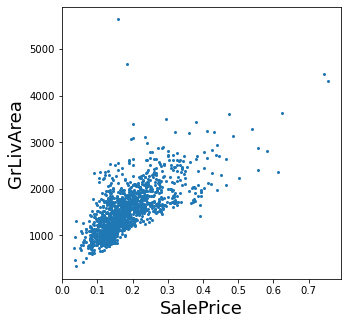

In [32]:
x_label = "SalePrice"
y_label = "GrLivArea"
plt.figure(figsize=(5, 5))
plt.scatter(df[x_label]*1e-6, df[y_label], s=4)
x = np.linspace(0, 15, 1)
plt.xlabel(x_label, fontsize=18)
plt.ylabel(y_label, fontsize=18);

In [33]:
# Deleting outliers
df = df[df.GrLivArea < 4500]
df.reset_index(drop=True, inplace=True)

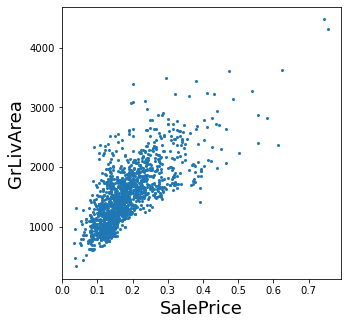

In [34]:
x_label = "SalePrice"
y_label = "GrLivArea"
plt.figure(figsize=(5, 5))
plt.scatter(df[x_label]*1e-6, df[y_label], s=4)
x = np.linspace(0, 15, 1)
plt.xlabel(x_label, fontsize=18)
plt.ylabel(y_label, fontsize=18);

In [35]:
# We use the numpy fuction log1p which  applies log(1+x) to all elements of the column
df["SalePrice"] = np.log1p(df["SalePrice"])
y = df.SalePrice.reset_index(drop=True)
df_features = df.drop(['SalePrice'], axis=1)

In [36]:
features = df_features
# Some of the non-numeric predictors are stored as numbers; we convert them into strings 
features['MSSubClass'] = features['MSSubClass'].apply(str)
features['YrSold'] = features['YrSold'].astype(str)
features['MoSold'] = features['MoSold'].astype(str)

In [37]:
features['Functional'] = features['Functional'].fillna('Typ')
features['Electrical'] = features['Electrical'].fillna("SBrkr")
features['KitchenQual'] = features['KitchenQual'].fillna("TA")
features['Exterior1st'] = features['Exterior1st'].fillna(features['Exterior1st'].mode()[0])
features['Exterior2nd'] = features['Exterior2nd'].fillna(features['Exterior2nd'].mode()[0])
features['SaleType'] = features['SaleType'].fillna(features['SaleType'].mode()[0])
features['PoolQC'] = features['PoolQC'].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    features[col] = features[col].fillna(0)
for col in ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']:
    features[col] = features[col].fillna('None')
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    features[col] = features[col].fillna('None')

features['MSZoning'] = features.groupby('MSSubClass')['MSZoning'].transform(lambda x: x.fillna(x.mode()[0]))

objects = []
for i in features.columns:
    if features[i].dtype == object:
        objects.append(i)

features.update(features[objects].fillna('None'))

features['LotFrontage'] = features.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# Filling in the rest of the NA's

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics.append(i)
features.update(features[numerics].fillna(0))

numeric_dtypes = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numerics2 = []
for i in features.columns:
    if features[i].dtype in numeric_dtypes:
        numerics2.append(i)

skew_features = features[numerics2].apply(lambda x: skew(x)).sort_values(ascending=False)

high_skew = skew_features[skew_features > 0.5]
skew_index = high_skew.index

for i in skew_index:
    features[i] = boxcox1p(features[i], boxcox_normmax(features[i] + 1))

features = features.drop(['Utilities', 'Street', 'PoolQC',], axis=1)

features['YrBltAndRemod']=features['YearBuilt']+features['YearRemodAdd']
features['TotalSF']=features['TotalBsmtSF'] + features['1stFlrSF'] + features['2ndFlrSF']

features['Total_sqr_footage'] = (features['BsmtFinSF1'] + features['BsmtFinSF2'] +
                                 features['1stFlrSF'] + features['2ndFlrSF'])

features['Total_Bathrooms'] = (features['FullBath'] + (0.5 * features['HalfBath']) +
                               features['BsmtFullBath'] + (0.5 * features['BsmtHalfBath']))

features['Total_porch_sf'] = (features['OpenPorchSF'] + features['3SsnPorch'] +
                              features['EnclosedPorch'] + features['ScreenPorch'] +
                              features['WoodDeckSF'])

# simplified features
features['haspool'] = features['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
features['has2ndfloor'] = features['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasgarage'] = features['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
features['hasbsmt'] = features['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
features['hasfireplace'] = features['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

print(features.shape)
final_features = pd.get_dummies(features).reset_index(drop=True)
print(final_features.shape)


(1458, 86)
(1458, 332)


In [38]:
# Synthesis test0 from train0
X_train, X_test, y_train, y_test = train_test_split(final_features, y, test_size=0.2, random_state=0)

In [39]:
outliers = [30, 88, 462, 631]
X_train = X_train.drop(X_train.index[outliers])
y_train = y_train.drop(y.index[outliers])

overfit = []
for i in X_train.columns:
    counts = X_train[i].value_counts()
    zeros = counts.iloc[0]
    if zeros / len(X_train) * 100 > 99.94:
        overfit.append(i)

overfit = list(overfit)
overfit.append('MSZoning_C (all)')

X_train = X_train.drop(overfit, axis=1).copy()
X_test = X_test.drop(overfit, axis=1).copy()

In [40]:
X_train.head()

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
1170,15.065616,9.016782,6,3.467927,1958,1958,0.000000,180.824740,0.000000,69.794785,...,0,0,0,1,0,0,0,0,1,0
75,7.227217,7.309339,4,3.040152,1973,1973,0.000000,137.395765,0.000000,0.000000,...,0,0,0,1,0,0,0,0,1,0
390,11.943214,8.936952,5,4.247350,1900,1950,0.000000,83.476684,10.699093,39.165484,...,0,0,0,1,0,0,0,0,1,0
1282,16.917011,9.046347,6,3.040152,1971,1971,0.000000,0.000000,0.000000,89.631224,...,0,0,0,1,0,0,0,0,1,0
682,16.522250,9.221776,9,3.040152,2002,2002,20.304063,258.704626,0.000000,67.545256,...,0,0,0,1,0,0,0,0,1,0


In [42]:
# ################## ML ########################################
print('START ML' )

kfolds = KFold(n_splits=10, shuffle=True, random_state=42)


# rmsle
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))


# build our model scoring function
def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y_train,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)


# setup models    
alphas_alt = [14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]
alphas2 = [5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]
e_alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007]
e_l1ratio = [0.8, 0.85, 0.9, 0.95, 0.99, 1]

ridge = make_pipeline(RobustScaler(),
                      RidgeCV(alphas=alphas_alt, cv=kfolds))

lasso = make_pipeline(RobustScaler(),
                      LassoCV(max_iter=1e7, alphas=alphas2,
                              random_state=42, cv=kfolds))

elasticnet = make_pipeline(RobustScaler(),
                           ElasticNetCV(max_iter=1e7, alphas=e_alphas,
                                        cv=kfolds, l1_ratio=e_l1ratio))
                                        
svr = make_pipeline(RobustScaler(),
                      SVR(C= 20, epsilon= 0.008, gamma=0.0003,))


gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =42)
                                   

lightgbm = LGBMRegressor(objective='regression', 
                                       num_leaves=4,
                                       learning_rate=0.01, 
                                       n_estimators=5000,
                                       max_bin=200, 
                                       bagging_fraction=0.75,
                                       bagging_freq=5, 
                                       bagging_seed=7,
                                       feature_fraction=0.2,
                                       feature_fraction_seed=7,
                                       verbose=-1,
                                       #min_data_in_leaf=2,
                                       #min_sum_hessian_in_leaf=11
                                       )
                                       

xgboost = XGBRegressor(learning_rate=0.01, n_estimators=3460,
                                     max_depth=3, min_child_weight=0,
                                     gamma=0, subsample=0.7,
                                     colsample_bytree=0.7,
                                     objective='reg:linear', nthread=-1,
                                     scale_pos_weight=1, seed=27,
                                     reg_alpha=0.00006)

# stack
stack_gen = StackingCVRegressor(regressors=(ridge, lasso, elasticnet,
                                            gbr, xgboost, lightgbm),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)
                                

print('TEST score on CV')

score = cv_rmse(ridge)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lasso)
print("Lasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(elasticnet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(svr)
print("SVR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(lightgbm)
print("Lightgbm score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

score = cv_rmse(gbr)
print("GradientBoosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()) )

score = cv_rmse(xgboost)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


START ML
TEST score on CV
Kernel Ridge score: 0.3599 (0.0368)

Lasso score: 0.3597 (0.0377)

ElasticNet score: 0.3615 (0.0377)

SVR score: 0.3634 (0.0372)

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warnin

In [43]:
print('START Fit')
print( 'StackingCVRegressor')
stack_gen_model = stack_gen.fit(np.array(X_train), np.array(y_train))
print( 'elasticnet')
elastic_model_full_data = elasticnet.fit(X_train, y_train)
print( 'lasso')
lasso_model_full_data = lasso.fit(X_train, y_train)
print( 'ridge')
ridge_model_full_data = ridge.fit(X_train, y_train)
print( 'svr')
svr_model_full_data = svr.fit(X_train, y_train)
print( 'GradientBoosting')
gbr_model_full_data = gbr.fit(X_train, y_train)
print( 'xgboost')
xgb_model_full_data = xgboost.fit(X_train, y_train)
print( 'lightgbm')
lgb_model_full_data = lightgbm.fit(X_train, y_train)

START Fit
StackingCVRegressor
[19:56:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[19:56:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignore

In [44]:
def blend_models_predict(X):
    return ((0.1 * elastic_model_full_data.predict(X)) + \
            (0.05 * lasso_model_full_data.predict(X)) + \
            (0.1 * ridge_model_full_data.predict(X)) + \
            (0.1 * svr_model_full_data.predict(X)) + \
            (0.1 * gbr_model_full_data.predict(X)) + \
            (0.15 * xgb_model_full_data.predict(X)) + \
            (0.1 * lgb_model_full_data.predict(X)) + \
            (0.3 * stack_gen_model.predict(np.array(X))))

print('RMSLE score on train data:')
print(rmsle(y_train, blend_models_predict(X_train)))
print('RMSLE score on test data:')
print(rmsle(y_test, blend_models_predict(X_test)))

RMSLE score on train data:
0.2465030038108439
RMSLE score on test data:
0.22913598188537837


In [45]:
final_df = np.expm1(y_test).values
final_df = pd.DataFrame(final_df,columns=['Real_price'])
final_df['predicted_prices'] = np.expm1(blend_models_predict(X_test)).astype(int)
final_df['difference'] = abs(final_df['Real_price'] - final_df['predicted_prices']).astype(int)
final_df.head(20)

,Real_price,predicted_prices,difference
0,145000.0,149898,4897
1,186000.0,170594,15406
2,87500.0,116554,29053
3,149900.0,150475,575
4,320000.0,230829,89171
5,115000.0,162776,47776
6,178400.0,172168,6232
7,128200.0,157549,29349
8,145000.0,153181,8180
9,104900.0,141643,36742
